## 1. A simulation exercise in regularization framework: sparsity in population coefficients

In [16]:
install.packages("xtable")
install.packages("hdm")
install.packages("glmnet")
install.packages("ggplot2")
install.packages("tidyr")

Warning message:
"package 'xtable' is in use and will not be installed"
Warning message:
"package 'hdm' is in use and will not be installed"
Warning message:
"package 'glmnet' is in use and will not be installed"
Warning message:
"package 'ggplot2' is in use and will not be installed"
Installing package into 'C:/Users/User/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\User\AppData\Local\Temp\RtmpmiL8US\downloaded_packages


In [17]:
library(hdm)
library(xtable)
library(glmnet)
library(ggplot2)
set.seed(12092024)

In [18]:
gen_data <- function(n, p, regime = "sparse") {
  # constants chosen to get R^2 of approximately .80
  if (regime == "sparse") {
    beta <- (1 / seq(1:p)^2) * 7
  } else if (regime == "dense") {
    beta <- rnorm(p) * 0.5
  }

  true_fn <- function(x) {
    x[, seq_len(dim(x)[2])] %*% beta
  }

  X <- matrix(runif(n * p, min = -0.5, max = 0.5), n, p)
  gX <- true_fn(X)
  y <- gX + rnorm(n)

  Xpop <- matrix(runif(100000 * p, min = -0.5, max = 0.5), 100000, p)
  gXpop <- true_fn(Xpop)
  ypop <- gXpop + rnorm(100000)

  return(list(
    X = X, y = y, gX = gX, Xpop = Xpop, ypop = ypop, gXpop = gXpop, beta = beta
  ))
}

## Approximate sparse coefficients

We are going to simulate a data generating process which coefficients vector is sparse. A set of coefficients is said to be approximate sparse if it satisfies the following property:


\begin{equation*}

\beta_j \propto \frac{1}{j^2}, \quad \forall j=1,2,\dots,p

\end{equation*}

In other words, the predictive power relies in a small subset of the coefficients vector (the larger ones).

In [19]:
n <- 100
p <- 400
res <- gen_data(n, p, regime = "sparse")

In [20]:
X <- res$X
y <- res$y
gX <- res$gX
Xpop <- res$Xpop
ypop <- res$ypop
gXpop <- res$gXpop
betas <- res$beta

We can plot the set of (sorted) coefficients' magnitude to visualize their behavior

function (x, y, ...) 
UseMethod("plot")
<bytecode: 0x000001ec78800c58>
<environment: namespace:base>

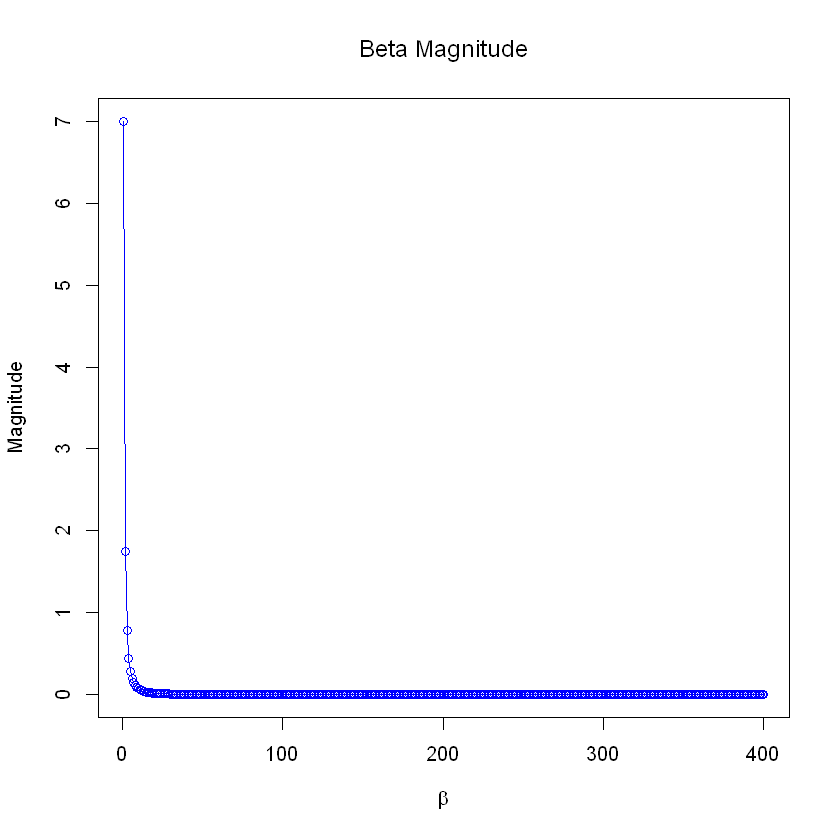

In [21]:
# Plot betas
plot(seq_along(betas), abs(betas), pch = 1, col = "blue",
  xlab = expression(beta), ylab = "Magnitude",
  main = expression(paste("Beta Magnitude"))
)
plot
lines(seq_along(betas), abs(betas), col = "blue")

As you may already notice, we are woking in a high dimensional setting ($p>n$). Let's test the dimensional reduction capabilities of the regularization methods. We would like to select only features which provide the most predictive power.

Remember that the general regularization problem (in p-norm) is the following:

\begin{equation*}

\min_{\beta_j \in \beta} \sum_{i=1}^{n}(Y_i - \beta^{\prime}X_i)^2 + \lambda\lVert \beta \lVert_p

\end{equation*}

where

\begin{equation*}

\lVert \beta \lVert_p = \left(\sum_{\beta_j \in \beta}\left|{\beta_{j}}^{p}\right|\right) ^{1/p}

\end{equation*}

When $p=1$, it is a Lasso (or L1) regularization . When $p=2$, it is a Ridge (or L2) regularization. We will explore the latter it in the next sessions

So, we fit a Lasso regularization. To tune the penalization parameter $\lambda$, we perform a cross-validation Lasso regression with $k=5$ folds.

In [22]:
model_l1 <- cv.glmnet(X, y, intercept = FALSE, family = "gaussian", alpha = 1, nfolds = 5)
betas_l1 <- coef(model_l1)[2:length(coef(model_l1))]

In [23]:
install.packages('caret')

Warning message:
"package 'caret' is in use and will not be installed"


If you want to do it from scratch, you can proceed as follows

In [24]:
# Required libraries
library(glmnet) # For Lasso
library(caret)  # For K-fold cross-validation

# Initialize parameters
upper_bound <- 1
niter <- 1000
alpha <- seq(0, upper_bound, length.out = niter)
n_splits <- 5
kf <- createFolds(y, k = n_splits, returnTrain = TRUE)

avg_mspe <- c()

# Cross-validation loop
for (i in alpha) {
  
  fold_pe <- c()
  
  for (train_index in kf) {
    
    X_train <- X[train_index,]
    y_train <- y[train_index]
    
    test_index <- setdiff(seq_len(nrow(X)), train_index)
    X_test <- X[test_index,]
    y_test <- y[test_index]
    
    # Fit Lasso model
    model <- glmnet(X_train, y_train, alpha = 1, lambda = i)
    
    # Predict
    predict <- predict(model, X_test)
    
    # Prediction error (MSPE)
    pe <- sum((y_test - predict)^2)
    
    fold_pe <- c(fold_pe, pe)
  }
  
  # Average MSPE for this alpha
  avg_mspe <- c(avg_mspe, mean(fold_pe))
}

# Choose the best alpha based on minimum MSPE
chosen_alpha <- alpha[which.min(avg_mspe)]

Let's see how the RMSE across folds behaves as lambda changes

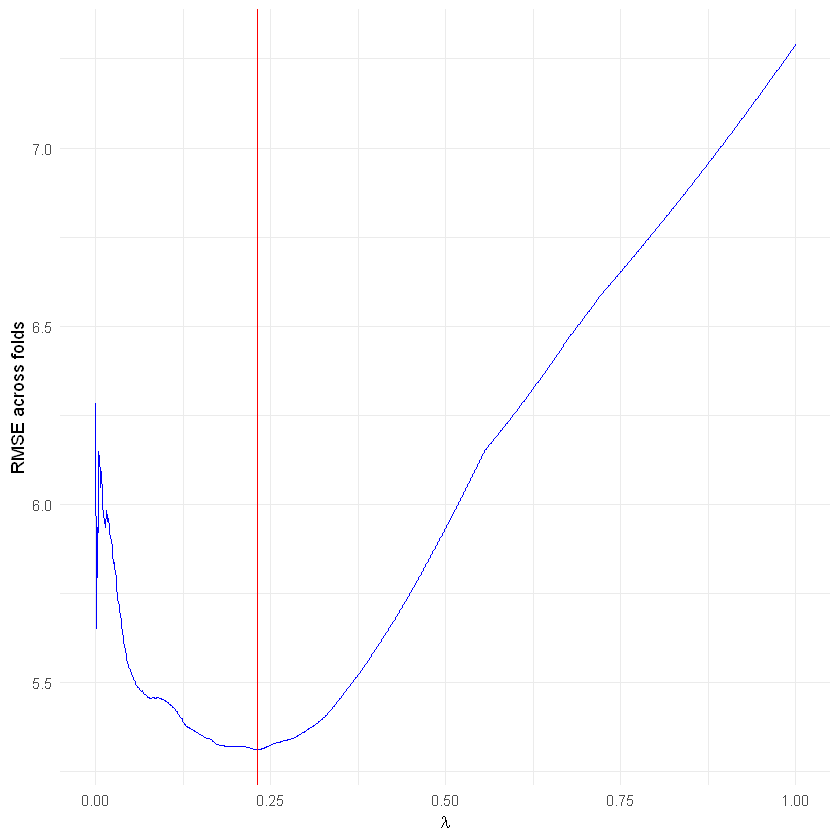

In [25]:
library(ggplot2)

rmse <- sqrt(avg_mspe)
plot_data <- data.frame(alpha = alpha, rmse = rmse)

ggplot(plot_data, aes(x = alpha, y = rmse)) +
  geom_line(color = 'blue') +                   
  geom_vline(xintercept = chosen_alpha, color = 'red') + 
  labs(x = expression(lambda), y = "RMSE across folds") + 
  theme_minimal()  

Let's plot the estimated coefficients from each regression

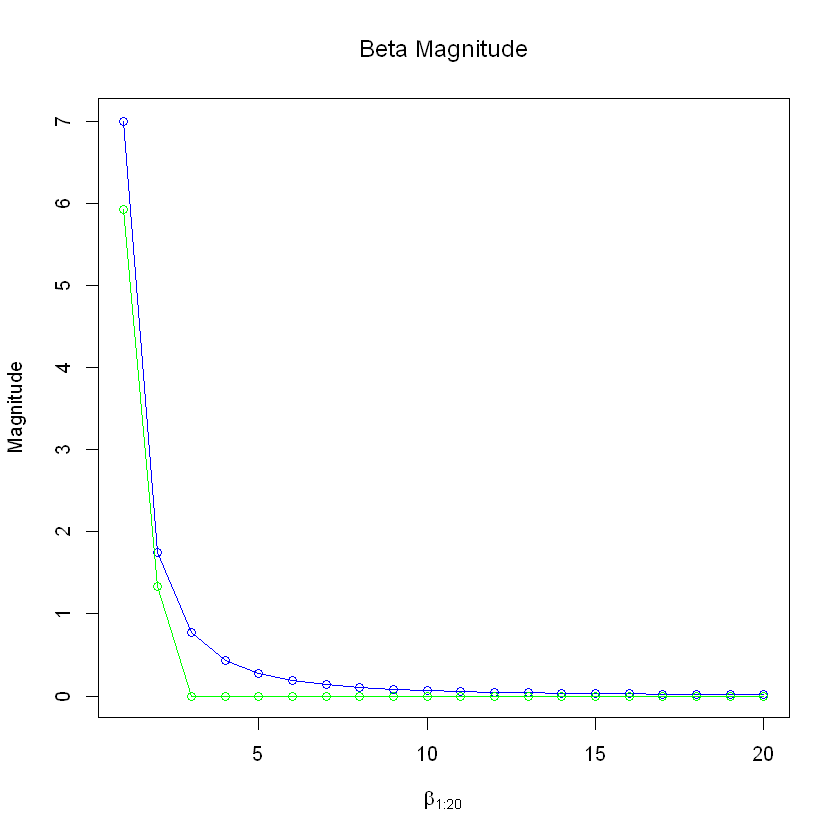

In [26]:
plot(seq_along(betas[1:20]), abs(betas[1:20]), pch = 1, col = "blue",
  xlab = expression(beta[1:20]), ylab = "Magnitude",
  main = expression(paste("Beta Magnitude"))
)
lines(seq_along(betas[1:20]), abs(betas[1:20]), col = "blue")

points(seq_along(betas_l1[1:20]), abs(betas_l1[1:20]), pch = 1, col = "green"
)
lines(seq_along(betas_l1[1:20]), abs(betas_l1[1:20]), col = "green")

The main conclusion of this exercise is that Lasso regularization fits scenearios of approximate sparse coefficients because it select a small subset with high predictive power. The linear predictor provided by Lasso may not be the BLP, but works well under high dimensionality.

In [46]:
install.packages("xtable")
install.packages("hdm")
install.packages("glmnet")
install.packages("ggplot2")
install.packages("tidyr")

Installing package into 'C:/Users/User/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\User\AppData\Local\Temp\RtmpmiL8US\downloaded_packages


## 2. A Simple Case Study using Wage Data from 2015

In [52]:
install.packages("xtable")
install.packages("hdm")
install.packages("glmnet")
install.packages("MLmetrics")

In [48]:
library(hdm)
library(xtable)
library(glmnet)
library(MLmetrics)

### Data

We consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [29]:
file <- "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data <- read.csv(file)
dim(data)

[1] 5150   20

In [30]:
Z <- subset(data, select = -c(lwage, wage)) # regressors
colnames(Z)

[1] "sex"  "shs"  "hsg"  "scl"  "clg"  "ad"   "mw"   "so"   "we"   "ne"  
[11] "exp1" "exp2" "exp3" "exp4" "occ"  "occ2" "ind"  "ind2"

The following figure shows the weekly wage distribution from the US survey data.

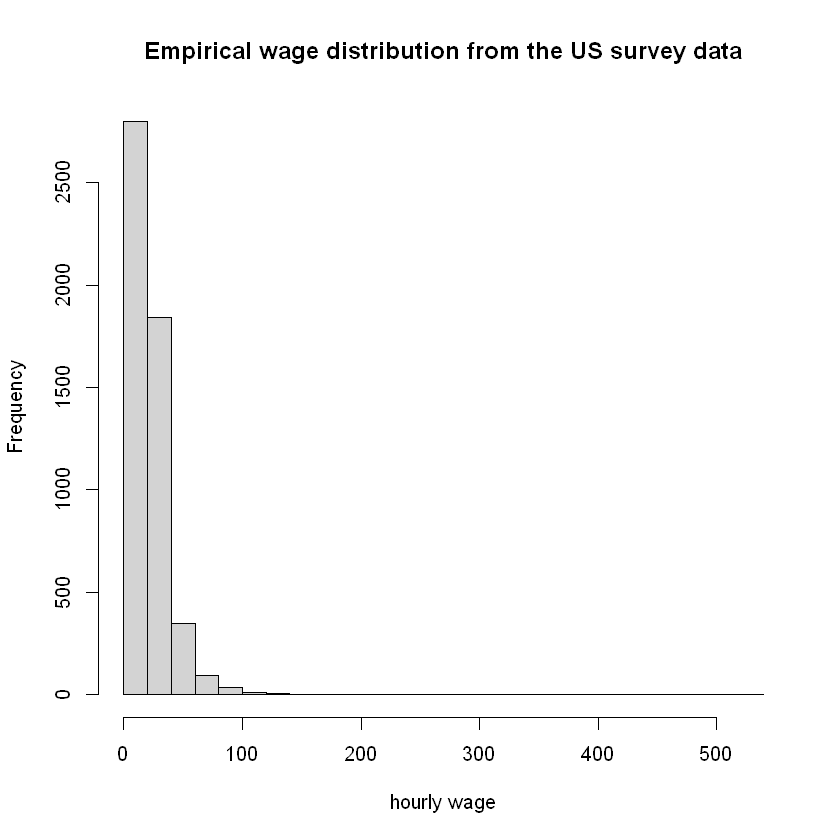

In [31]:
hist(data$wage, xlab = "hourly wage", main = "Empirical wage distribution from the US survey data", breaks = 35)

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by the logarithm.

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

In this notebook, we will evaluate *linear* prediction rules. In later notebooks, we will also utilize nonlinear prediction methods. In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$

Again, we generate $X$ in three ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

To evaluate the out-of-sample performance, we split the data first.

As known from our first lab, the basic model consists of $51$ regressors, and the flexible model has $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression and computing the $R^2$ on the test sample.

### Low dimensional specification (basic)

In [32]:
set.seed(1234)
training <- sample(nrow(data), nrow(data) * (3 / 4), replace = FALSE)

data_train <- data[training, ]
data_test <- data[-training, ]

In [33]:
y_train <- data_train$lwage
y_test <- data_test$lwage

In [34]:
x_basic <- "sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2)+ C(ind2)"
formula_basic <- as.formula(paste("lwage", "~", x_basic))
model_x_basic_train <- model.matrix(formula_basic, data_train)
model_x_basic_test <- model.matrix(formula_basic, data_test)
p_basic <- dim(model_x_basic_train)[2]
p_basic

[1] 51

In [35]:
# ols (basic model)
fit_lm_basic <- lm(formula_basic, data_train)
# Compute the Out-Of-Sample Performance
yhat_lm_basic <- predict(fit_lm_basic, newdata = data_test)
cat("Basic model MSE (OLS): ", mean((y_test - yhat_lm_basic)^2)) # MSE OLS (basic model)

Warning message:
"contrasts dropped from factor C(occ2)"
Warning message:
"contrasts dropped from factor C(ind2)"


Basic model MSE (OLS):  0.2275178

In [36]:
mse_lm_basic <- summary(lm((y_test - yhat_lm_basic)^2 ~ 1))$coef[1:2]
mse_lm_basic

[1] 0.2275178 0.0156360

Let's calculate R-squared on the test set

In [37]:
r2_lm_basic <- 1 - mse_lm_basic[1] / var(y_test)
cat("Basic model R^2 (OLS): ", r2_lm_basic) # MSE OLS (basic model)

Basic model R^2 (OLS):  0.2877383

### High-dimensional specification (flexible)

We repeat the same procedure for the flexible model.

In [38]:
x_flex <- paste("sex + exp1 + shs + hsg + scl + clg + C(occ2) + C(ind2) + mw + so + we ",
                "+ (exp1 + exp2 + exp3 + exp4) * (shs + hsg + scl + clg + C(occ2) + C(ind2) + mw + so + we)")
formula_flex <- as.formula(paste("lwage", "~", x_flex))
model_x_flex_train <- model.matrix(formula_flex, data_train)
model_x_flex_test <- model.matrix(formula_flex, data_test)
p_flex <- dim(model_x_flex_train)[2]


In [39]:
p_flex

[1] 246

In [40]:
# ols (flexible model)
fit_lm_flex <- lm(formula_flex, data_train)

In [41]:
# Compute the Out-Of-Sample Performance
options(warn = -1)
yhat_lm_flex <- predict(fit_lm_flex, newdata = data_test)
mse_lm_flex <- summary(lm((y_test - yhat_lm_flex)^2 ~ 1))$coef[1:2]
r2_lm_flex <- 1 - mse_lm_flex[1] / var(y_test)
cat("Flexible model R^2 (OLS): ", r2_lm_flex) 

Flexible model R^2 (OLS):  0.2383204

### Penalized regressions (flexible model)

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We proceed by running a Lasso regression for the flexible model, tuned via cross-validation.

In R's glmnet function, variables are automatically standarized

In [42]:
fit_lasso_cv_flex <- cv.glmnet(model_x_flex_train, y_train, family = "gaussian", alpha = 1)
yhat_lasso_cv_flex <- predict(fit_lasso_cv_flex, newx = model_x_flex_test)
mse_lasso_cv_flex <- summary(lm((y_test - yhat_lasso_cv_flex)^2 ~ 1))$coef[1:2]
r2_lasso_cv_flex <- 1 - mse_lasso_cv_flex[1] / var(y_test)
cat("Flexible model R^2 (Lasso): ", r2_lasso_cv_flex)

Flexible model R^2 (Lasso):  0.2794449

In [56]:
fit_rlasso <- hdm::rlasso(y ~ X, post = FALSE) # lasso with plug-in penalty level
fit_rlasso$lambda0


[1] 40.3636

In sum, Lasso provides a better out of sample predictive accuracy in the flexible model in a high dimensional setting,